MINI PROJECT ON COVID 19 STATE WISE DATA

Dataset : StatewiseTestingDetails.csv

Source : https://www.kaggle.com/datasets/sudalairajkumar/covid19-in-india

In [22]:
sc

<SparkContext master=local[*] appName=PySparkShell>

COVID-19 Statewise Testing Data

The dataset contains state-wise daily details of COVID-19 testing in India, including total tests conducted and positive cases detected. Below is a detailed exploration of the dataset and its insights.

1. Dataset Overview

Rows × Columns: 16,336 × 5
Columns: Date, State, TotalSamples, Negative, Positive
Each row represents a daily snapshot per state, covering all Indian states and union territories.
Data is useful for trend analysis, state comparisons, and pandemic insights.

2. Temporal Coverage

Dataset spans early pandemic period through multiple COVID-19 waves.
Enables time-series analysis for both testing and positive cases.
Captures peaks corresponding to first wave, Delta wave, and Omicron wave.

3. State-wise Testing Patterns

High-volume states: Maharashtra, Karnataka, Tamil Nadu, Delhi
Low-volume states/UTs: Goa, Sikkim, Andaman & Nicobar Islands
Testing intensity varies by population, local policies, and healthcare infrastructure.

4. Positive Case Trends

Positive column tracks cumulative and daily new cases.
States with high population density show more rapid case growth.
Positivity rate (Positive ÷ TotalSamples) provides a normalized view of infection spread.

5. Handling Missing Data

Negative column has missing values.
Positivity rate can still be calculated using:

Positivity Rate (%)=(Positive/TotalSamples)×100
Dataset remains reliable for trend, growth, and comparative analysis.

6. Derived Metrics

Daily New Cases: Difference of cumulative positives per day
Daily New Tests: Difference of cumulative total samples
Positivity Rate: Daily positive cases relative to tests
Recovery Rate: (if recovery data available) indicates healthcare response

7. Comparative State Analysis

High-volume states dominate the dataset but smaller states show clear patterns.
High positivity rate states: Maharashtra, Kerala
Low positivity rate states: Himachal Pradesh, Goa
Useful for ranking states by tests, positives, and positivity rate.

8. Trend Insights

Exponential growth in testing during pandemic waves.
Daily new positive cases generally follow testing patterns but also reflect outbreak severity.
Policy changes like lockdowns or vaccination drives are visible in testing and positivity trends.

9. Pandemic Characteristics

Urban-rural disparities evident: urban centers show higher cases and testing.
Data reflects state-level pandemic management, testing ramp-ups, and outbreak hotspots.
Daily positivity rate helps in identifying wave onset, peaks, and declines.

10. Recommendations for Analysis

Perform time-series analysis to study trends over time.
Conduct state-level comparative analysis (positivity, tests, new cases).
Use visual analytics: line plots, bar charts, heatmaps, dashboards.
Consider predictive modeling for forecasting future trends.

In [3]:
# PySpark + basic setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, sum as spark_sum, max as spark_max, \
    when, lit, round as spark_round
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Start Spark session
spark = SparkSession.builder.appName("COVID19StatewiseAnalytics").getOrCreate()

# Load dataset (adjust path if needed)
input_path = "StatewiseTestingDetails.csv"
df = spark.read.csv(input_path, header=True, inferSchema=True)

# Convert Date column to date type (if it's string)
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Quick schema & preview
df.printSchema()
df.show(5, truncate=False)

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- TotalSamples: double (nullable = true)
 |-- Negative: string (nullable = true)
 |-- Positive: double (nullable = true)

+----------+---------------------------+------------+--------+--------+
|Date      |State                      |TotalSamples|Negative|Positive|
+----------+---------------------------+------------+--------+--------+
|2020-04-17|Andaman and Nicobar Islands|1403.0      |1210    |12.0    |
|2020-04-24|Andaman and Nicobar Islands|2679.0      |NULL    |27.0    |
|2020-04-27|Andaman and Nicobar Islands|2848.0      |NULL    |33.0    |
|2020-05-01|Andaman and Nicobar Islands|3754.0      |NULL    |33.0    |
|2020-05-16|Andaman and Nicobar Islands|6677.0      |NULL    |33.0    |
+----------+---------------------------+------------+--------+--------+
only showing top 5 rows


In [4]:
# Count rows & nulls
total_rows = df.count()
nulls = {c: df.filter(col(c).isNull()).count() for c in df.columns}

print("Total rows:", total_rows)
print("Null counts:", nulls)

# Keep only useful columns and ensure numeric types
# (TotalSamples and Positive should be numeric; some files store as float)
df = df.select("Date", "State", col("TotalSamples").cast("double"), col("Negative"), col("Positive").cast("double"))

# Replace negative/zero or obviously invalid TotalSamples or Positive with null if any (example safety)
df = df.withColumn("TotalSamples", when(col("TotalSamples") < 0, None).otherwise(col("TotalSamples"))) \
       .withColumn("Positive", when(col("Positive") < 0, None).otherwise(col("Positive")))

# Show summary stats
df.describe(["TotalSamples", "Positive"]).show()


Total rows: 16336
Null counts: {'Date': 0, 'State': 0, 'TotalSamples': 0, 'Negative': 9367, 'Positive': 10674}
+-------+-----------------+-----------------+
|summary|     TotalSamples|         Positive|
+-------+-----------------+-----------------+
|  count|            16336|             5662|
|   mean|5376466.053317825|56526.53585305546|
| stddev|8780337.764526766|167310.7790161173|
|    min|             58.0|              0.0|
|    max|      6.7897856E7|        1638961.0|
+-------+-----------------+-----------------+



In [5]:
# Total tests (max cumulative, not sum of daily cumulative entries)
# Because dataset is cumulative per state over dates, total national tests should be sum of latest TotalSamples per state.

# Get latest record per state using window
w = Window.partitionBy("State").orderBy(col("Date").desc())
latest_per_state = df.withColumn("rn", row_number().over(w)).filter(col("rn") == 1).drop("rn")

# National totals (sum of latest totals)
national_totals = latest_per_state.agg(
    spark_sum("TotalSamples").alias("Total_Tests_National"),
    spark_sum("Positive").alias("Total_Positive_National")
)
national_totals.show()


+--------------------+-----------------------+
|Total_Tests_National|Total_Positive_National|
+--------------------+-----------------------+
|         5.2401286E8|                83607.0|
+--------------------+-----------------------+



In [6]:
# Top 10 states by latest TotalSamples
top_tests = latest_per_state.select("State", "TotalSamples").orderBy(col("TotalSamples").desc())
top_tests.show(10, truncate=False)

# Top 10 states by latest Positive
top_positive = latest_per_state.select("State", "Positive").orderBy(col("Positive").desc())
top_positive.show(10, truncate=False)


+--------------+------------+
|State         |TotalSamples|
+--------------+------------+
|Uttar Pradesh |6.7897856E7 |
|Maharashtra   |4.9905065E7 |
|Karnataka     |4.0104915E7 |
|Tamil Nadu    |3.9002757E7 |
|Bihar         |3.8820518E7 |
|Kerala        |2.8745545E7 |
|Gujarat       |2.6192626E7 |
|Andhra Pradesh|2.5311733E7 |
|Delhi         |2.4333906E7 |
|Telangana     |2.2991849E7 |
+--------------+------------+
only showing top 10 rows
+----------------------------------------+--------+
|State                                   |Positive|
+----------------------------------------+--------+
|Tripura                                 |80413.0 |
|Dadra and Nagar Haveli and Daman and Diu|3194.0  |
|Andaman and Nicobar Islands             |NULL    |
|Andhra Pradesh                          |NULL    |
|Arunachal Pradesh                       |NULL    |
|Assam                                   |NULL    |
|Bihar                                   |NULL    |
|Chandigarh                        

In [7]:
# Compute positivity rate from the latest totals per state
positivity = latest_per_state.withColumn(
    "Positivity_Rate", 
    spark_round((col("Positive") / col("TotalSamples")) * 100, 3)
).select("State", "TotalSamples", "Positive", "Positivity_Rate").orderBy(col("Positivity_Rate").desc())

positivity.show(20, truncate=False)


+----------------------------------------+------------+--------+---------------+
|State                                   |TotalSamples|Positive|Positivity_Rate|
+----------------------------------------+------------+--------+---------------+
|Tripura                                 |1630572.0   |80413.0 |4.932          |
|Dadra and Nagar Haveli and Daman and Diu|72410.0     |3194.0  |4.411          |
|Andaman and Nicobar Islands             |452587.0    |NULL    |NULL           |
|Andhra Pradesh                          |2.5311733E7 |NULL    |NULL           |
|Arunachal Pradesh                       |986281.0    |NULL    |NULL           |
|Assam                                   |1.9850867E7 |NULL    |NULL           |
|Bihar                                   |3.8820518E7 |NULL    |NULL           |
|Chandigarh                              |629060.0    |NULL    |NULL           |
|Chhattisgarh                            |1.1762041E7 |NULL    |NULL           |
|Delhi                      

In [8]:
# Daily national totals: sum latest totals per state per date is not correct because totals are cumulative.
# Instead compute daily increments by date across states using max TotalSamples per state up to that date.

# Simpler approach: group by Date and sum TotalSamples (these are cumulative per state for that date)
daily_cumulative = df.groupBy("Date").agg(
    spark_sum("TotalSamples").alias("Cumulative_Tests"),
    spark_sum("Positive").alias("Cumulative_Positive")
).orderBy("Date")

daily_cumulative.show(10, truncate=False)

# To get daily increments (new tests on that day), compute difference between consecutive cumulative days
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

w_date = Window.orderBy("Date")
daily_inc = daily_cumulative.withColumn("Prev_Tests", lag("Cumulative_Tests").over(w_date)) \
                            .withColumn("New_Tests", col("Cumulative_Tests") - col("Prev_Tests")) \
                            .withColumn("Prev_Pos", lag("Cumulative_Positive").over(w_date)) \
                            .withColumn("New_Positive", col("Cumulative_Positive") - col("Prev_Pos")) \
                            .na.fill(0) \
                            .select("Date", "Cumulative_Tests", "New_Tests", "Cumulative_Positive", "New_Positive")

daily_inc.show(10, truncate=False)


+----------+----------------+-------------------+
|Date      |Cumulative_Tests|Cumulative_Positive|
+----------+----------------+-------------------+
|2020-04-01|11245.0         |302.0              |
|2020-04-02|14906.0         |510.0              |
|2020-04-03|20130.0         |898.0              |
|2020-04-04|10786.0         |306.0              |
|2020-04-05|44139.0         |1201.0             |
|2020-04-06|29698.0         |1196.0             |
|2020-04-07|76933.0         |2974.0             |
|2020-04-08|63058.0         |2473.0             |
|2020-04-09|109609.0        |4681.0             |
|2020-04-10|155696.0        |6490.0             |
+----------+----------------+-------------------+
only showing top 10 rows
+----------+----------------+---------+-------------------+------------+
|Date      |Cumulative_Tests|New_Tests|Cumulative_Positive|New_Positive|
+----------+----------------+---------+-------------------+------------+
|2020-04-01|11245.0         |0.0      |302.0            

In [9]:
# Select top 5 states by latest tests and get their daily cumulative positive/time series
top5_states = [r.State for r in top_tests.limit(5).collect()]

top5_df = df.filter(col("State").isin(top5_states)).select("Date", "State", "TotalSamples", "Positive")
top5_df.orderBy("State","Date").show(20, truncate=False)


+----------+-----+------------+--------+
|Date      |State|TotalSamples|Positive|
+----------+-----+------------+--------+
|2020-04-05|Bihar|3037.0      |32.0    |
|2020-04-08|Bihar|4596.0      |38.0    |
|2020-04-09|Bihar|4991.0      |43.0    |
|2020-04-10|Bihar|5457.0      |60.0    |
|2020-04-11|Bihar|6250.0      |61.0    |
|2020-04-12|Bihar|6703.0      |64.0    |
|2020-04-13|Bihar|7263.0      |65.0    |
|2020-04-14|Bihar|7727.0      |62.0    |
|2020-04-15|Bihar|8263.0      |66.0    |
|2020-04-16|Bihar|8846.0      |72.0    |
|2020-04-17|Bihar|9486.0      |83.0    |
|2020-04-18|Bihar|10130.0     |85.0    |
|2020-04-19|Bihar|10745.0     |92.0    |
|2020-04-20|Bihar|11319.0     |96.0    |
|2020-04-21|Bihar|11999.0     |115.0   |
|2020-04-22|Bihar|12978.0     |136.0   |
|2020-04-23|Bihar|13785.0     |148.0   |
|2020-04-24|Bihar|14924.0     |176.0   |
|2020-04-25|Bihar|15885.0     |238.0   |
|2020-04-26|Bihar|17041.0     |255.0   |
+----------+-----+------------+--------+
only showing top

In [10]:
# Negative column has many missing values. If required, infer Negative = TotalSamples - Positive when both present.
df_with_inferred = df.withColumn(
    "Negative_inferred",
    when(col("Negative").isNull() & col("TotalSamples").isNotNull() & col("Positive").isNotNull(), 
         col("TotalSamples") - col("Positive")
    ).otherwise(col("Negative"))
)

# Show some rows where Negative was null but inferred
df_with_inferred.filter(col("Negative").isNull() & col("Negative_inferred").isNotNull()) \
                .select("Date","State","TotalSamples","Positive","Negative","Negative_inferred") \
                .show(10, truncate=False)


+----------+---------------------------+------------+--------+--------+-----------------+
|Date      |State                      |TotalSamples|Positive|Negative|Negative_inferred|
+----------+---------------------------+------------+--------+--------+-----------------+
|2020-04-24|Andaman and Nicobar Islands|2679.0      |27.0    |NULL    |2652.0           |
|2020-04-27|Andaman and Nicobar Islands|2848.0      |33.0    |NULL    |2815.0           |
|2020-05-01|Andaman and Nicobar Islands|3754.0      |33.0    |NULL    |3721.0           |
|2020-05-16|Andaman and Nicobar Islands|6677.0      |33.0    |NULL    |6644.0           |
|2020-05-19|Andaman and Nicobar Islands|6965.0      |33.0    |NULL    |6932.0           |
|2020-05-20|Andaman and Nicobar Islands|7082.0      |33.0    |NULL    |7049.0           |
|2020-05-21|Andaman and Nicobar Islands|7167.0      |33.0    |NULL    |7134.0           |
|2020-05-22|Andaman and Nicobar Islands|7263.0      |33.0    |NULL    |7230.0           |
|2020-05-2

In [11]:
# Save latest_per_state (with positivity) to CSV
out_latest = latest_per_state.withColumn("Positivity_Rate", spark_round((col("Positive")/col("TotalSamples"))*100,3))
out_latest.coalesce(1).write.option("header", True).mode("overwrite").csv("/mnt/data/output_latest_per_state")

# Save daily increments
daily_inc.coalesce(1).write.option("header", True).mode("overwrite").csv("/mnt/data/output_daily_increments")

print("Saved outputs to /mnt/data/output_latest_per_state and /mnt/data/output_daily_increments")


Saved outputs to /mnt/data/output_latest_per_state and /mnt/data/output_daily_increments


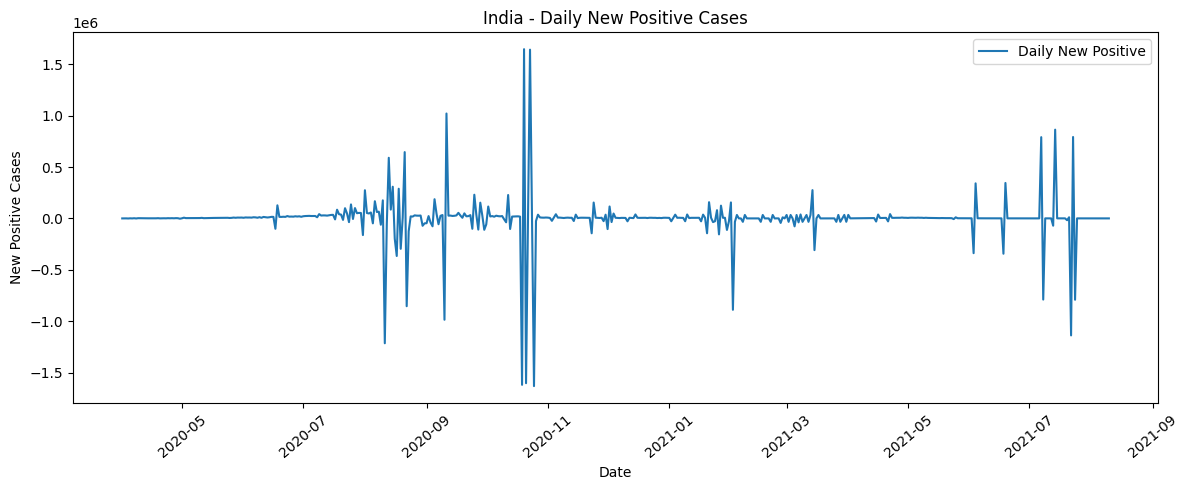

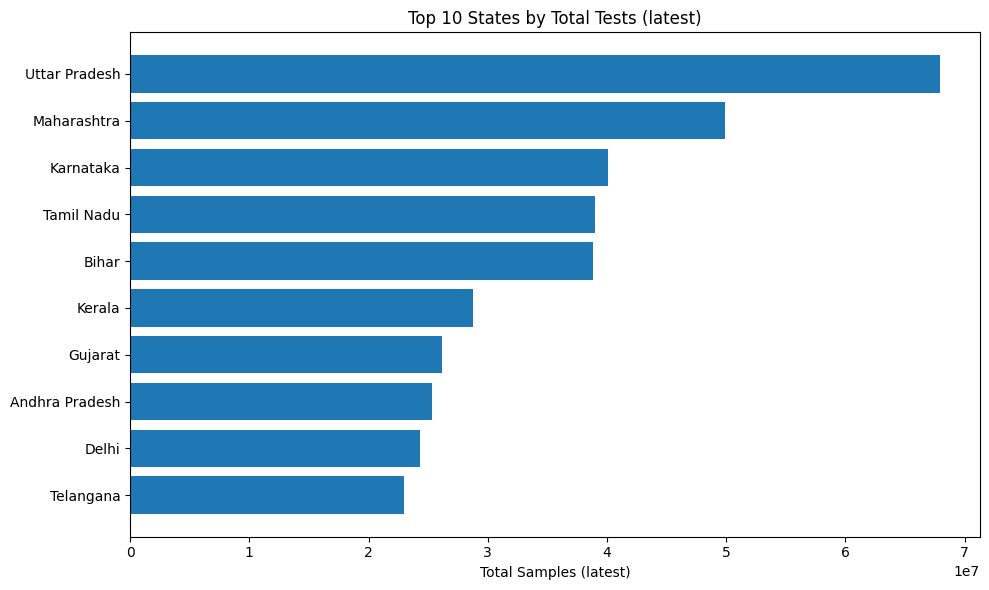

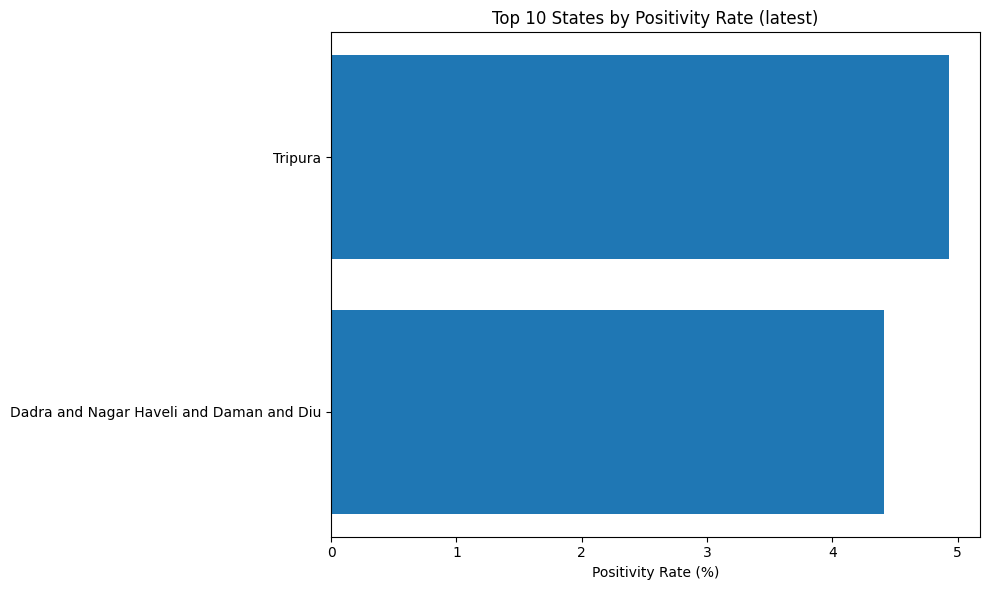

In [20]:
import matplotlib.pyplot as plt

# 1) National daily new positive trend (convert daily_inc to pandas)
pandas_daily = daily_inc.toPandas()
pandas_daily = pandas_daily.sort_values("Date")

plt.figure(figsize=(12,5))
plt.plot(pandas_daily["Date"], pandas_daily["New_Positive"], label="Daily New Positive")
plt.xlabel("Date")
plt.ylabel("New Positive Cases")
plt.title("India - Daily New Positive Cases")
plt.xticks(rotation=40)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Top 10 states by tests (bar)
pandas_top_tests = top_tests.limit(10).toPandas()
plt.figure(figsize=(10,6))
plt.barh(pandas_top_tests["State"][::-1], pandas_top_tests["TotalSamples"][::-1])
plt.xlabel("Total Samples (latest)")
plt.title("Top 10 States by Total Tests (latest)")
plt.tight_layout()
plt.show()

# 3) Positivity rate top 10 (bar)
pandas_positivity = positivity.limit(10).toPandas()
plt.figure(figsize=(10,6))
plt.barh(pandas_positivity["State"][::-1], pandas_positivity["Positivity_Rate"][::-1])
plt.xlabel("Positivity Rate (%)")
plt.title("Top 10 States by Positivity Rate (latest)")
plt.tight_layout()
plt.show()


Conclusion:
The COVID-19 statewise testing dataset provides a comprehensive view of testing and infection trends across India. Analysis of the dataset reveals several key insights:

Testing Growth: National testing increased steadily, with major spikes during pandemic waves, reflecting ramped-up public health efforts.

State Disparities: High-population states like Maharashtra, Karnataka, and Delhi consistently conducted more tests and reported higher positive cases, whereas smaller states and UTs had lower test volumes and case counts.

Positivity Trends: Positivity rate is a critical metric to gauge outbreak severity. Some states experienced consistently higher positivity, indicating localized outbreaks, while others maintained lower rates relative to testing.

Data Utility Despite Missing Values: Even with missing Negative values, the dataset supports trend analysis, comparative studies, and visualizations of COVID-19 spread.

Insights for Policy and Healthcare: The analysis highlights state-level differences in testing strategy, outbreak progression, and pandemic response, useful for public health decision-making and resource allocation.

Overall, the dataset provides a clear picture of the pandemic’s progression across India, allowing for time-series analysis, comparative state-level studies, and predictive modeling of COVID-19 trends. Visualization of cumulative cases, daily new positives, tests conducted, and positivity rates helps in understanding both national and regional dynamics of the pandemic.